# Emotion-Recognition CK+ Model V13

## Note:

I will note include all the information about hardware and dataset, for reference check V1.

In [1]:
# Imports
import psutil as ps
import GPUtil as gpx
import platform
from tabulate import tabulate
from datetime import datetime
import seedir as sd
import matplotlib.pyplot as plt
import plotly.graph_objects as pgo
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dense, Input, Dropout,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF

## Dataset


In [2]:
# This time I will perform more complex data augmentation
training_datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)
training_generator = training_datagen.flow_from_directory(
        '../../../datasets/CKplus_training_dataset/',
        target_size=(48, 48),
        batch_size=32,
        class_mode="categorical",
        color_mode="grayscale",
        shuffle=True,
        )

validation_datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        '../../../datasets/CKplus_testing_dataset/',
        target_size=(48, 48),
        batch_size=32,
        class_mode="categorical",
        color_mode="grayscale",
        shuffle=True,
        )

Found 265 images belonging to 7 classes.
Found 62 images belonging to 7 classes.


## Neural Network Model

I will try to simplify the model.

In [3]:
# Initialising the CNN
model = Sequential()

# Convolutional Layer N.1
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Convolutional Layer N.2
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Convolutional Layer N.3
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


# Now we flatten the volume to pass it to the fully connected layers
model.add(Flatten())

# Now we create the first fully connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))


# Now we create the output [7 is the number of classes]
# We use softmax since it's for multi-classification
model.add(Dense(7, activation="softmax"))

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

## Training

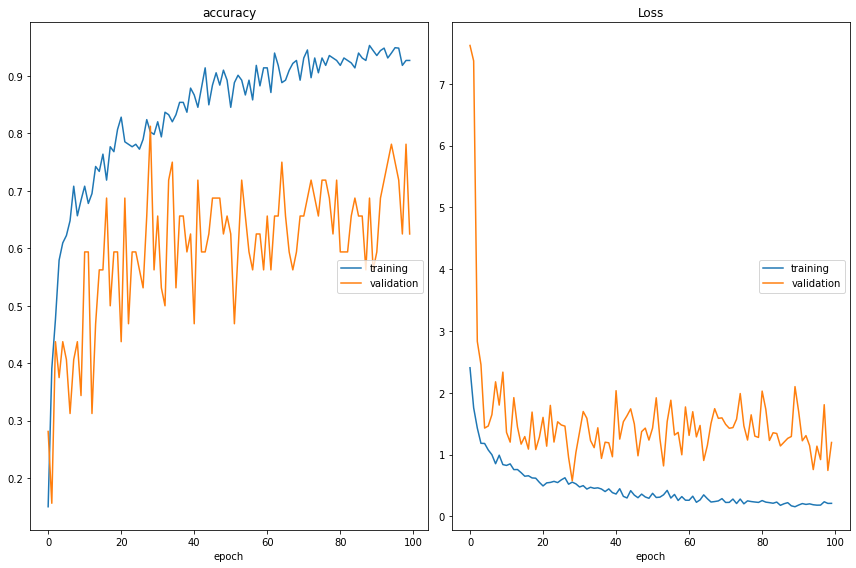

accuracy
	training         	 (min:    0.150, max:    0.953, cur:    0.927)
	validation       	 (min:    0.156, max:    0.812, cur:    0.625)
Loss
	training         	 (min:    0.155, max:    2.405, cur:    0.210)
	validation       	 (min:    0.575, max:    7.621, cur:    1.195)


In [4]:
# Set epochs and validation steps and steps per epoch
epochs = 100
steps_per_epoch = training_generator.n//training_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Optimizer [tweak for how much time training will take]
model.compile(optimizer=Adam(lr=0.0005), loss="categorical_crossentropy", metrics=["accuracy"])
callbacks = [PlotLossesKerasTF()]

# Train the model
history = model.fit(
    x=training_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

### Reuslts

Add more data augmentation seems to help initially with the validation accuracy, but still the values flactuate too much since it's overfitting. On v14 I will try to increase the learning rate.

### Save the Model

In [5]:
# I save the model
model.save("ck_model_gen13.h5")

# serialize the model to json
model_json = model.to_json()
# save the model architecture to JSON file
with open("ck_model_gen13.json", "w") as json_file:
    json_file.write(model_json)

model_yaml = model.to_yaml()
with open("ck_model_gen13.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [6]:
# Convert model to TensorFlowJS
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'tensorflowJS')